<a href="https://colab.research.google.com/github/theresaskruzna/riiid_knowledge_tracing/blob/main/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# Riiid Knowledge Tracing Project
# Initial setup and data exploration

# This installs the Kaggle API package. The -q flag makes the installation "quiet" (less verbose output).
# This only needs to be run once per Colab session
!pip install -q kaggle

# This imports the files module from Google Colab and opens a file upload dialog where you select your Kaggle API credentials file (kaggle.json) from your local computer.
# Upload your kaggle.json file (from your Kaggle account settings)
from google.colab import files

import kagglehub
import os
import pickle
import gc # Import the garbage collector module

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


# Load datasets

## Load original dataset

In [2]:
files.upload()  # Upload your kaggle.json here

!mkdir -p ~/.kaggle # Creates a .kaggle directory in your home folder (~) if it doesn't already exist. The -p flag ensures no error is thrown if the directory already exists.
!cp kaggle.json ~/.kaggle/ # Copies the uploaded kaggle.json file to the .kaggle directory where the Kaggle API expects to find it.
!chmod 600 ~/.kaggle/kaggle.json # Sets permissions on the kaggle.json file to "read/write for owner only" (600). This is required by the Kaggle API for security reasons.

# Download the dataset
!kaggle competitions download -c riiid-test-answer-prediction # Downloads all files for the Riiid Test Answer Prediction competition. The -c flag specifies which competition.
!unzip -q riiid-test-answer-prediction.zip -d riiid_data # Extracts the downloaded zip file into a directory called "riiid_data". The -q flag makes the unzip operation quiet (less verbose).

Saving kaggle.json to kaggle (1).json
riiid-test-answer-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
replace riiid_data/example_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace riiid_data/lectures.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace riiid_data/questions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace riiid_data/riiideducation/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace riiid_data/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
n
n


In [3]:
# This command will list all files and directories within the "riiid_data" directory in a detailed format.
!ls -la riiid_data/

total 5710060
drwxr-xr-x 3 root root       4096 Mar 16 14:26 .
drwxr-xr-x 1 root root       4096 Mar 16 14:25 ..
-rw-r--r-- 1 root root        971 Oct 14  2020 example_sample_submission.csv
-rw-r--r-- 1 root root       6137 Oct 14  2020 example_test.csv
-rw-r--r-- 1 root root       9703 Oct 14  2020 lectures.csv
-rw-r--r-- 1 root root     296161 Oct 14  2020 questions.csv
drwxr-xr-x 2 root root       4096 Mar 16 12:33 riiideducation
-rw-r--r-- 1 root root 5846760913 Oct 14  2020 train.csv


In [4]:
# This command lists detailed information about the specific file kaggle.json in the .kaggle directory in your home folder.
!ls -la ~/.kaggle/kaggle.json

-rw------- 1 root root 70 Mar 16 14:25 /root/.kaggle/kaggle.json


Loading questions.csv and lectures.csv into the notebook.

In [5]:
# Load the dataset with memory optimisations

# Define column data types to reduce memory usage
dtype_mapping_questions = {
    "question_id": "int16",
    "bundle_id": "int16",
    "correct_answer": "int8",
    "part": "int8",
    "tags": "object"
}

dtype_mapping_lectures = {
    "lecture_id": "int16",
    "part": "int8",
    "tag": "int16",
    "type_of": "object",
}

In [6]:
%%time

questions_df = pd.read_csv('riiid_data/questions.csv', dtype=dtype_mapping_questions)

CPU times: user 13 ms, sys: 5.32 ms, total: 18.3 ms
Wall time: 37.9 ms


In [7]:
%%time

lectures_df = pd.read_csv('riiid_data/lectures.csv', dtype=dtype_mapping_lectures)

CPU times: user 4.64 ms, sys: 115 µs, total: 4.75 ms
Wall time: 4.41 ms


## Load pickle dataset

The original train.csv data set is too large (5.85GB) for processing in collab, thus, a more suitable data set that has been compressed and converted from .csv to .pkl.gzip will be used for the time series forecasting purposes.
This approach downloads the whole dataset but I will look into ways to change it to dowloading just the single file I need.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("rohanrao/riiid-train-data-multiple-formats")

print("Path to dataset files:", path)

os.listdir(path)

Path to dataset files: /root/.cache/kagglehub/datasets/rohanrao/riiid-train-data-multiple-formats/versions/3


['riiid_train.parquet',
 'riiid_train.feather',
 'riiid_train.pkl.gzip',
 'riiid_train.h5',
 'riiid_train.jay']

Ignore the code cell below for now

In [ ]:
# List all files in the directory
all_files = os.listdir('riiid_data')

# Loop through files and remove if not 'train.pkl.gzip'
for file in all_files:
    if file != 'train.pkl.gzip':
        os.remove(os.path.join('riiid_data', file))

IsADirectoryError: [Errno 21] Is a directory: 'riiid_data/riiideducation'

In [ ]:
# Load the dataset with memory optimisations

# Define column data types to reduce memory usage
dtype_mapping_train = {
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32",
    "prior_question_had_explanation": "boolean"
}

# Define which colums to use
usecols_train=[1, 2, 3, 4, 5, 7, 8, 9],

In [ ]:
%%time

# Load the dataset
train_df = pd.read_pickle(f"{path}/riiid_train.pkl.gzip")

CPU times: user 2.01 s, sys: 4.8 s, total: 6.81 s
Wall time: 23.4 s


# Data pre-processing

Drop row_id and user_answer columns

In [ ]:
# Check mememory usage before optimisation
def memory_usage(df):
    return f"{df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB"

print(f"Dataset shape: {train_df.shape}")
print(f"Memory usage before optimisation: {memory_usage(train_df)}")

Dataset shape: (101230332, 10)
Memory usage before optimisation: 6463.74 MB


In [ ]:
# Drop the row_id and user_answer columns to save memory
train_df.drop(['row_id', 'user_answer'], axis=1, inplace=True) # axis=1 for columns, axis=0 for rows, inplace=True  modifies original df

# Check memory usage after dropping columns
print(f"Memory usage after dropping columns: {memory_usage(train_df)}")

Memory usage after dropping columns: 5594.87 MB


In [ ]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,False,1,1,NaN,None
1,56943,115,5716,False,2,1,37000.0,False
2,118363,115,128,False,0,1,55000.0,False
3,131167,115,7860,False,3,1,19000.0,False
4,137965,115,7922,False,4,1,11000.0,False


Define column data types

In [ ]:
# Define column data types to reduce memory usage
dtype_mapping_train = {
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32",
    "prior_question_had_explanation": "boolean"
}

In [ ]:
# Cast columns to the desired data types
for column, data_type in dtype_mapping_train.items():
    train_df[column] = train_df[column].astype(data_type)  # Direct assignment

# Check memory usage after datatype conversions
print(f"Memory usage after datatype conversions: {memory_usage(train_df)}")

Memory usage after datatype conversions: 2413.52 MB


## Data cleaning

### Missing values

#### train.pkl

In [ ]:
missing_values = train_df.isna().sum().to_frame('missing_values')
missing_values

,missing_values
timestamp,0
user_id,0
content_id,0
content_type_id,0
task_container_id,0
answered_correctly,0
prior_question_elapsed_time,2351538
prior_question_had_explanation,392506


In [ ]:
# Calculate the percentage of missing values
missing_values = (train_df.isna().sum() / len(train_df) * 100).to_frame('% of missing values')
missing_values.style.format({'% of missing values': '{:.2f}%'})  # Format to two decimal places with % sign

# Display the results
print(missing_values)

                                % of missing values
timestamp                                  0.000000
user_id                                    0.000000
content_id                                 0.000000
content_type_id                            0.000000
task_container_id                          0.000000
answered_correctly                         0.000000
prior_question_elapsed_time                2.322958
prior_question_had_explanation             0.387736


There are 2 columns with missing values:

prior_question_elapsed_time

prior_question_had_explanation

It is stated in the feature description section of the original dataset that for the said features, where it's the user's first question bundle or lecture, the value is always NULL.

This most likely means that there are no values to be recorded, therefore we impute the NULL values with a distinct value -1, that would be unlikely to occur naturally, to preserve the remaining information in the row.

In [ ]:
# Fill in missing values with "-1"
train_df["prior_question_elapsed_time"] = train_df["prior_question_elapsed_time"].fillna(-1)
train_df["prior_question_had_explanation"] = train_df["prior_question_had_explanation"].fillna(False)

# Display the first few rows to verify (optional)
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,False,1,1,-1.0,False
1,56943,115,5716,False,2,1,37000.0,False
2,118363,115,128,False,0,1,55000.0,False
3,131167,115,7860,False,3,1,19000.0,False
4,137965,115,7922,False,4,1,11000.0,False


In [ ]:
# Calculate the percentage of missing values
missing_values = (train_df.isna().sum() / len(train_df) * 100).to_frame('% of missing values')
missing_values.style.format({'% of missing values': '{:.2f}%'})  # Format to two decimal places with % sign

# Display the results
print(missing_values)

                                % of missing values
timestamp                                       0.0
user_id                                         0.0
content_id                                      0.0
content_type_id                                 0.0
task_container_id                               0.0
answered_correctly                              0.0
prior_question_elapsed_time                     0.0
prior_question_had_explanation                  0.0


#### questions.csv

In [ ]:
missing_values = questions_df.isna().sum().to_frame('missing_values')
missing_values

,missing_values
question_id,0
bundle_id,0
correct_answer,0
part,0
tags,1


In [ ]:
missing_tag_row = questions_df[questions_df['tags'].isnull()]
missing_tag_row

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


Only 1 missing value for the 'tags' variable - at this size of a dataset, the entire row can probably be deleted, however, as the question_id is a foreign key for the main dataset, it's important to check what is the reprasentation of this particular question in that dataset.


In [ ]:
missing_question_id = missing_tag_row['question_id'].iloc[0]  # Extract the question_id
question_id_counts = train_df[train_df['content_id'] == missing_question_id].shape[0]

print(f"Occurrences of question_id {missing_question_id}: {question_id_counts}")

Occurrences of question_id 10033: 1


In [ ]:
row = train_df.loc[train_df['content_id'] == 10033]
print(row)

           timestamp     user_id  content_id  content_type_id  \
62750278  1286282597  1333688829       10033            False   

          task_container_id  answered_correctly  prior_question_elapsed_time  \
62750278               1127                   1                      35000.0   

          prior_question_had_explanation  
62750278                            True  


The question_id 10033 is only found once across the whole train.pkl.gzip dataset with 101+ million rows so it's safe to say we can delete that row from question_df as well as train_df.

In [ ]:
questions_df = questions_df.dropna(subset=['tags'])  # Drop rows with missing 'tags'

In [ ]:
train_df = train_df.drop(train_df[train_df['content_id'] == 10033].index)

In [ ]:
missing_question_id = missing_tag_row['question_id'].iloc[0]  # Extract the question_id
question_id_counts = train_df[train_df['content_id'] == missing_question_id].shape[0]

print(f"Occurrences of question_id {missing_question_id}: {question_id_counts}")

Occurrences of question_id 10033: 0


### Outliers

#### Functions

In [ ]:
def plot_boxplot(data, x=None, y=None, hue=None, color=None, title=None, horizontal=False):
    """
    Creates a customizable box plot.

    Parameters:
    - data: Pandas DataFrame containing the data.
    - x: Column name for the x-axis (categorical).
    - y: Column name for the y-axis (numeric).
    - hue: Optional column for additional grouping.
    - color: Optional color for the boxes.
    - title: Optional title for the plot.
    - horizontal: Boolean to plot horizontally (default is vertical).
    """

    sample_size = 100000  # Define sample size here
    # Sample the data if it's larger than the sample size
    if len(data) > sample_size:
        data = data.sample(n=sample_size)  # Random sampling without replacement

    # Set orientation
    orient = 'h' if horizontal else 'v'

    plt.figure(figsize=(5, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call
    sns.boxplot(data=data, x=x, y=y, hue=hue, orient=orient) # Create the boxplot

    # Custom labels and title
    if horizontal:
        plt.xlabel(y)  # In horizontal orientation, y values are on x-axis
        plt.ylabel(x)  # In horizontal orientation, x values are on y-axis
    else:
        plt.xlabel(x)
        plt.ylabel(y)
        # In vertical orientation, x values are on x-axis, y values are on y-axis
    if title:
        plt.title(title) # add title to plot if provided in function call

    # Handle label rotation for vertical plots with many categories
    if orient == 'v' and x is not None:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout() # adjusts the plot padding to ensure all labels fit within the figure without being cut off
    plt.show() # display plot

# Example usage:
# plot_boxplot(df, x='category', y='value')                  # Basic vertical boxplot
# plot_boxplot(df, x='value', y='category', orient='h')      # Horizontal boxplot
# plot_boxplot(df, x='category', y='value', hue='group')     # Grouped boxplot

    # additional parameters
    # xlabel=None, ylabel=None, figsize=(8, 5), orient='v', showfliers=True, palette=None
    """
    Parameters:
    - color: Optional color for the boxes.
    - xlabel: Optional x-axis label.
    - ylabel: Optional y-axis label.
    - figsize: Tuple defining the figure size (default=(8,5)).
    - orient: Orientation of the plot ('v' for vertical, 'h' for horizontal).
    - showfliers: Whether to show outlier points (default=True).
    - palette: Color palette for groups when hue is specified.
    """

#### timestamp

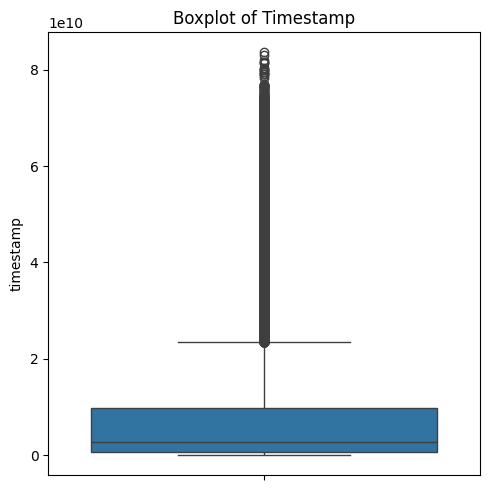

In [ ]:
plot_boxplot(train_df, y="timestamp", title="Boxplot of Timestamp")

Is it ok to erase pretty much 10% of data as outliers or is it valuable data for our predicitions?

In [ ]:
# Total rows we started with
total = len(train_df)
feature = "timestamp"

# Compute Outliers
Q1 = np.percentile(train_df[feature].values, q = 25)
Q3 = np.percentile(train_df[feature].values, q = 75)
IQR = Q3 - Q1

# We'll look only at the upper interval outliers
outlier_boundry = Q3 + 1.5*IQR

print('Timestamp: around {:.2}% of the data would be erased.'.format(len(train_df[train_df[feature] >= outlier_boundry])/total * 100),
      "\n"+
      'The outlier boundry is {:,}, which means {:,.5} hrs, which means {:,.5} days.'.format(outlier_boundry, (outlier_boundry / 3.6e+6), (outlier_boundry / 3.6e+6)/24))

gc.collect()

Timestamp: around 9.4% of the data would be erased. 
The outlier boundry is 24,024,861,244.75, which means 6,673.6 hrs, which means 278.07 days.


100

The very high values for timestamp show us users that have engaged with the platform for close to a year and up to nearly 3 years. This seems like a valuable data we don't want to lose as we can calculate their progress from that.

#### Engagement count among users

It could potentially be beneficial to erase data for users with low engagement count, e.g. 5, and treat it as outliers. However, these could be fairly new users so have to be careful there to delete their data too as it could have good value for comparison with long standing users and their success on the platform.

In [ ]:
user_id_counts = train_df.groupby('user_id').size()

# Display in tabular format
print(user_id_counts)

user_id
115            46
124            30
2746           20
5382          128
8623          112
             ... 
2147470770    228
2147470777    758
2147481750     50
2147482216    280
2147482888     27
Length: 393656, dtype: int64


In [ ]:
# Basic descriptive statistics
print("Minimum occurrences:", user_id_counts.min())
print("Maximum occurrences:", user_id_counts.max())
print("Average occurrences:", user_id_counts.mean())
print("Median occurrences:", user_id_counts.median())

Minimum occurrences: 1
Maximum occurrences: 17917
Average occurrences: 257.15429461255513
Median occurrences: 41.0


In [ ]:
# Quantiles (e.g., 25th, 50th, 75th percentiles)
quantiles = user_id_counts.quantile([0.25, 0.5, 0.75])
print(quantiles)

0.25     30.0
0.50     41.0
0.75    157.0
dtype: float64


In [ ]:
# Specific percentiles (e.g., 90th, 95th, 99th)
percentiles = user_id_counts.quantile([0.9, 0.95, 0.99])
print(percentiles)

0.90     590.00
0.95    1175.00
0.99    3504.45
dtype: float64


In [ ]:
# Specific percentiles (e.g., 1st, 25th, 10th)
percentiles = user_id_counts.quantile([0.01, 0.05, 0.1])
print(percentiles)

0.01    11.0
0.05    14.0
0.10    17.0
dtype: float64


In [ ]:
# Export to a CSV file
user_id_counts.to_csv('user_id_counts.csv', header=['count'])
print("User ID counts saved to user_id_counts.csv")

User ID counts saved to user_id_counts.csv


In [ ]:
# Group by 'user_id' and count occurrences
user_engagement_counts = train_df.groupby('user_id').size()

# Filter for users with only one engagement
single_engagement_users = user_engagement_counts[user_engagement_counts == 1]

# Count the number of such users
num_single_engagement_users = len(single_engagement_users)

# Print the result
print(f"Number of people who engaged only once: {num_single_engagement_users}")

Number of people who engaged only once: 87


In [ ]:
# Group by 'user_id' and count occurrences
user_engagement_counts = train_df.groupby('user_id').size()

# Filter for users with engagements between 1 and 5
engagement_range_users = user_engagement_counts[
    (user_engagement_counts >= 1) & (user_engagement_counts <= 11)
]

# Count the number of such users
num_engagement_range_users = len(engagement_range_users)

# Print the result
print(
    "Number of people who engaged between 1 and 5 times:"
    f" {num_engagement_range_users}"
)

Number of people who engaged between 1 and 5 times: 3946


In [ ]:
# Group by 'user_id' and count occurrences
user_engagement_counts = train_df.groupby('user_id').size()

# Filter for users with engagements between 1 and 11
users_to_remove = user_engagement_counts[
    (user_engagement_counts >= 1) & (user_engagement_counts <= 11)
].index

# Remove those users from the main DataFrame
train_df = train_df[~train_df['user_id'].isin(users_to_remove)]

In [ ]:
# Calculate the number of rows removed
rows_removed = len(user_engagement_counts[ (user_engagement_counts >= 1) & (user_engagement_counts <= 11)])

# Print the number of removed rows
print(f"Number of rows removed: {rows_removed}")

Number of rows removed: 0


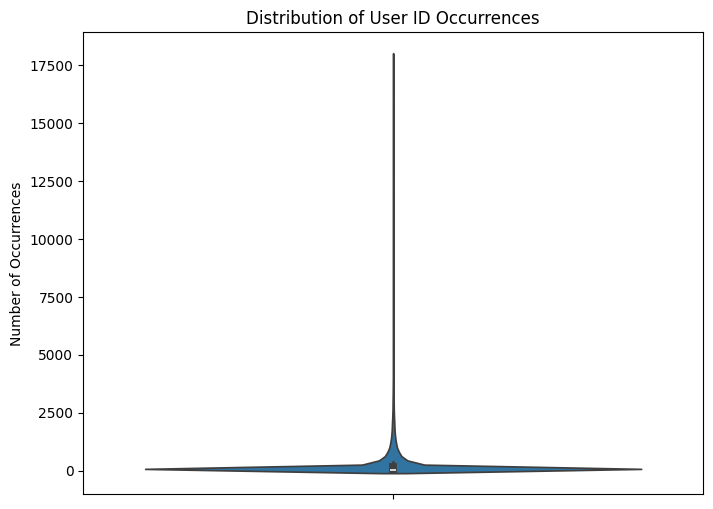

In [ ]:
# violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(y=user_id_counts)
plt.title("Distribution of User ID Occurrences")
plt.ylabel("Number of Occurrences")
plt.show()

In [ ]:
# Select numerical columns
numerical_cols = maths.select_dtypes(include=np.number).columns

# Calculate the number of rows and columns for the subplots
num_cols = 5  # Number of columns per row
num_rows = int(np.ceil(len(numerical_cols) / num_cols))  # Calculate the number of rows needed

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot KDEs in a loop
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=maths[col], fill=True, ax=axes[i])
    axes[i].set_title(f'Density of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide any extra empty subplots
for i in range(len(numerical_cols), num_rows * num_cols):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate z-scores for each column
z_scores = np.abs((maths_encoded - maths_encoded.mean()) / maths_encoded.std())

# Set threshold for z-scores (e.g., 4 standard deviations from the mean)
threshold = 4

# Remove outliers
maths_clean = maths_encoded[(z_scores < threshold).all(axis=1)]
maths_clean.reset_index(drop=True, inplace=True)

# Verify the number of rows before and after
print("Original dataset rows:", maths_encoded.shape[0])
print("Dataset rows after removing outliers:", maths_clean.shape[0])

# Save the cleaned dataset
maths_clean.to_csv("cleaned_dataset_no_outliers.csv", index=False)

# Print the updated DataFrame (uncomment)
# print(maths_clean)

### Scaling

In [ ]:
# zajistíme stejné měřítko provšechny sloupce od 0 - 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# convert to a dataframe, for better readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.head()

In [ ]:
# Select the numerical columns for standardization
num_col = maths_encoded.select_dtypes(include=['number']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the numerical columns
maths_encoded_standardized = maths_encoded.copy()  # Create a copy to avoid modifying the original
maths_encoded_standardized[num_col] = scaler.fit_transform(maths_encoded[num_col])

# Display the first few rows of the standardized data
maths_encoded_standardized.head()

# EDA

## Feature exploration

### train

The 'timestamp' variable has values as high as 87 billion miliseconds which tells me nothing so I decided to convert it to days to get a better perspective on what that means for the dataset.

In [ ]:
max_timestamp = train_df['timestamp'].max()
max_days = max_timestamp / (1000 * 60 * 60 * 24)  # Convert milliseconds to days
max_years = max_days / 365.25  # Convert days to years (accounting for leap years)

print(f"Maximum timestamp in days: {max_days}")
print(f"Maximum timestamp in years: {max_years}")

Maximum timestamp in days: 1011.8723616782407
Maximum timestamp in years: 2.7703555418979895


So thats about 2 and 3/4 of a year between interactions for the particular user so will have to explore if that is quite unique in the dataset and could be considered an outlier or if the time data really spans that much in general.

How many unique users in the dataset?

In [ ]:
num_unique_users = train_df['user_id'].nunique()
print(f"Number of unique users: {num_unique_users}")

Number of unique users: 393656


The 'content_id' is basically an 'question_id' form question.csv or 'lecture_id' from lecture.csv datasets and then the 'content_type_id' defines which one of these is it in the train.pkl.gzip dataset.

It's boolean where False means if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

In [ ]:
train_df.content_type_id.value_counts()

,count
content_type_id,
False,99271300
True,1959032


In [ ]:
num_unique_content = train_df['content_id'].nunique()
print(f"Number of unique content: {num_unique_content}")

# Calculate and print unique questions and lectures in one line
print(f"Unique questions: {train_df[train_df.content_type_id == False].content_id.nunique()}\nUnique lectures: {train_df[train_df.content_type_id == True].content_id.nunique()}")

Number of unique content: 13782
Unique questions: 13523
Unique lectures: 415


It seems that users are given questions in containers and then seeing explanations for them and potentially answers which then may hekp with answering the next batch of questions.

In [ ]:
unique_task_container = train_df['task_container_id'].nunique()
print(f"Number of unique task containers: {unique_task_container}")

Number of unique task containers: 10000


The variable 'user_answer' refers to what choice they picked out of multiple answer questions, numbers 0-3 refer to 4 choices, and number -1 means they engaged with a lecture instead.
THIS FEATURE WAS DROPPED FROM THE DATASET.

The count for -1 (lectures) checks with the count in 'content_type_id'.

The variable 'answered_correctly' tells us if users got the question right(1) or wrong(0), or if they engaged with a lecture instead(-1). This is also the target variable for this analysis.

In [ ]:
answered_correctly_counts = train_df.answered_correctly.value_counts()
print(answered_correctly_counts)

answered_correctly
 1    65244627
 0    34026673
-1     1959032
Name: count, dtype: int64


The maxiumum elapsed time since last question asked could also potentially have some outliers where people don't finish the container or leave the device withiut answering the question.

In [ ]:
max_elapsed_time = train_df['prior_question_elapsed_time'].max()
max_minutes = max_elapsed_time / 60000  # Convert milliseconds to minutes
print(f"Maximum elapsed time: {max_minutes}")

Maximum elapsed time: 5.0


There probably is a cut off at 5 minutes per question.

The last variable in the dataset is probably going to be quite imporatant to compare to predicting if the answers to questions were correct. It states in the description that in the beginning the questions asked were onboarding Qs so there wouldnt be feedback but as a student would progress on the platform they would be given some.

In [ ]:
train_df.prior_question_had_explanation.value_counts()


,count
prior_question_had_explanation,
True,89685560
False,11152266


In [ ]:
percentages = train_df.prior_question_had_explanation.value_counts(normalize=True) * 100
percentages

,proportion
prior_question_had_explanation,
True,88.940394
False,11.059606


### questions

question_id - How many unique questions in the dataset?

In [ ]:
num_unique_questions = questions_df['question_id'].nunique()
print(f"Number of unique questions: {num_unique_questions}")

Number of unique questions: 13523


bundle_id - How many unique question bundles in the dataset?

In [ ]:
num_unique_bundles = questions_df['bundle_id'].nunique()
print(f"Number of unique question bundles: {num_unique_bundles}")

Number of unique question bundles: 9765


correct_answer

In [ ]:
questions_df.correct_answer.value_counts()

,count
correct_answer,
0,3716
3,3544
1,3478
2,2785


part - the relevant section of the TOEIC test.

https://www.iibc-global.org/english/toeic/test/lr/about/format.html

The Test of English for International Communication (TOEIC) is an international standardized test of English language proficiency for non-native speakers.

In [ ]:
questions_df.part.value_counts()

,count
part,
5,5511
2,1647
3,1562
4,1439
6,1212
7,1160
1,992


tags

In [ ]:
num_unique_tags = questions_df['tags'].nunique()
print(f"Number of unique tags: {num_unique_tags}")

Number of unique tags: 1519


### lectures

lecture_id - How many unique lectures in the dataset?

In [ ]:
num_unique_lectures = lectures_df['lecture_id'].nunique()
print(f"Number of unique lectures: {num_unique_lectures}")

Number of unique lectures: 418


part - TOEIC test

https://www.iibc-global.org/english/toeic/test/lr/about/format.html

The Test of English for International Communication (TOEIC) is an international standardized test of English language proficiency for non-native speakers.

In [ ]:
lectures_df.part.value_counts()

,count
part,
5,143
6,83
2,56
1,54
7,32
4,31
3,19


tag

In [ ]:
num_unique_tags = lectures_df['tag'].nunique()
print(f"Number of unique tags: {num_unique_tags}")

Number of unique tags: 151


type_of

In [ ]:
lectures_df.type_of.value_counts()

,count
type_of,
concept,222
solving question,186
intention,7
starter,3


## Visualisations

### Functions

KDE plot

In [ ]:
def plot_kde(data, column, hue=None, title=None):
    """
    Creates a simple KDE plot for a specified column.

    Parameters:
    - data: Pandas DataFrame
    - column: Column name to plot
    - hue: Optional categorical column for grouping
    - title: Optional plot title
    """

    plt.figure(figsize=(8, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call

    # Sample large datasets for better performance
    if len(data) > 250000 and hue is None:
        # Create a sampled version of data for very large datasets
        sampled_data = data.iloc[::250000]
        sns.kdeplot(data=sampled_data, x=column, fill=True) # create KDE plot
    else:
        # Use the full dataset for normal-sized data or when using hue
        sns.kdeplot(data=data, x=column, hue=hue, fill=True) # create KDE plot
        # df, column, split into categories if provided, fill area under line with colour

    # Custom labels and title
    plt.xlabel(column) # horizontal line label
    # plt.xlabel(xlabel if xlabel else column) - alternate code to add label
    plt.ylabel("Density") # vertical line label
    if title:
        plt.title(title) # add title to plot if provided in function call

    plt.show() # display plot

    # --- Added code for descriptive statistics ---
    # Assume 'column' is numerical by default
    categorical = False

    # Check if the column is of object (string) type, which often represents categorical data
    if data[column].dtype == 'object':
        categorical = True

    if categorical:
        values = data[column].value_counts().values
    else:
        # Apply sampling for large datasets here too
        if len(data) > 250000:
            values = data[column].values[::250000]
        else:
            values = data[column].values

    print('Mean: {:,}'.format(np.mean(values)))
    print('Median: {:,}'.format(np.median(values)))
    print('Max: {:,}'.format(np.max(values)))
    # --- End of added code ---

# Example usage:
# plot_kde(df, 'column_name', hue='category_column', title='KDE Plot')

# additional parameters:
# bw_adjust=1, color=None, xlabel=None, ylabel="Density", figsize=(8, 5)
    """
    Parameters:
    - bw_adjust: Bandwidth adjustment factor (default=1).
    - color: Optional color for the KDE curve.
    - xlabel: Optional x-axis label.
    - ylabel: Y-axis label (default="Density").
    - figsize: Tuple defining the figure size (default=(8,5)).
    """

Bar plot

In [ ]:
def plot_bar(data, x, y=None, hue=None, color=None, title=None, rotate_labels=True):
    """
    Creates a customizable bar plot.

    Parameters:
    - data: Pandas DataFrame containing the data.
    - x: Column name for the x-axis categories.
    - y: Optional column name for the y-axis values (if None, counts are used).
    - hue: Optional column for grouping (creates grouped bars).
    - color: Optional color for the bars.
    - title: Optional title for the plot.
    - xlabel: Optional x-axis label (default uses x column name).
    - ylabel: Optional y-axis label (default uses y column name or "Count").
    - figsize: Tuple defining the figure size (default=(8,5)).
    """
    plt.figure(figsize=(8, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call

    # Sample data if it's large and hue is not used
    if len(data) > sample_size and hue is None:
        sampled_data = data.sample(sample_size)  # Random sampling
    else:
        sampled_data = data

    # Create either a value plot or count plot
    # If y is provided, plot values; otherwise plot counts
    if y:
        sns.barplot(data=data, x=x, y=y, hue=hue, color=color)
    else:
        sns.countplot(data=data, x=x, hue=hue, color=color)

    # Custom labels and title
    plt.xlabel(x) # horizontal line label
    # plt.xlabel(xlabel if xlabel else x) - alternate code to add label
    plt.ylabel(y if y else "Count") # vertical line label
    if title:
        plt.title(title) # add title to plot if provided in function call

    # Rotate x-axis labels if there are many categories to prevent label overlap
    if rotate_labels: # Rotate labels conditionally
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout() # adjusts the plot padding to ensure all labels fit within the figure without being cut off

    plt.show() # display plot

# Example usage:
# plot_bar(df, x='category_column')                       # Simple count plot
# plot_bar(df, x='category_column', y='value_column')     # Value-based bar plot
# plot_bar(df, x='category_column', hue='group_column')   # Grouped bar plot

# additional parameters:
# hue=None, color=None, xlabel=None, ylabel=None, figsize=(8, 5)
    """
    Parameters:
    - hue: Optional column for grouping (creates grouped bars).
    - color: Optional color for the bars.
    - xlabel: Optional x-axis label (default uses x column name).
    - ylabel: Optional y-axis label (default uses y column name or "Count").
    - figsize: Tuple defining the figure size (default=(8,5)).
    """

Histogram

In [ ]:
def plot_histogram(data, column, bins=None, hue=None, title=None):
    """
    Creates a simple histogram for a specified column.

    Parameters:
    - data: Pandas DataFrame
    - column: Column name to plot
    - bins: Optional number of bins (none/default uses seaborn's auto bin selection)
    - hue: Optional categorical column for grouping
    - title: Optional plot title
    """
    plt.figure(figsize=(8, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call
    sns.histplot(data=data, x=column, bins=bins, hue=hue, kde=True) # create histogram
    # df, column, number of bins, split into categories if provided, line on top of the histogram bars

    # Custom labels and title
    plt.xlabel(column) # horizontal line label
    # plt.xlabel(xlabel if xlabel else column) - alternate code to add label
    plt.ylabel("Count") # vertical line label
    if title:
        plt.title(title) # add title to plot if provided in function call

    plt.show() # display plot

# Example usage:
# plot_histogram(df, 'column_name', bins=20, hue='category_column', title='Histogram')

# additional parameters:
# color='blue', xlabel=None, ylabel="Count", figsize=(10, 6), kde=False)
    """
    Parameters:
    - color: Optional color for the histogram bars.
    - xlabel: Optional x-axis label (default uses column name).
    - ylabel: Y-axis label (default="Count").
    - figsize: Tuple defining the figure size (default=(8,5)).
    - kde: Boolean to include KDE curve overlay (default=True).
    """

### timestamp and prior_question_elapsed_time

In [ ]:
numerical_columns = ['timestamp', 'prior_question_elapsed_time']

for column in numerical_columns:
    plot_kde(train_df, column=column, hue=None, title=column + " distribution")

Histogram for timestamp? Most distribution is within the first 2 months of signing up to the platform - every user starts with 0 value for their first log - does the number of 0 values for timestamp check with number of users?

Check unique number count for user_id

In [ ]:
plot_histogram(train_df, 'timestamp', bins=20, hue=None, title=None)

### user_id, content_id and task_container_id

In [ ]:
categorical_columns = ['user_id', 'content_id', 'task_container_id']

for column in categorical_columns:
    plot_kde(train_df, column=column, hue=None, title=column + " countplot distribution")

### content_type_id, answered_correctly and prior_question_had_explanation

In [ ]:
categorical_columns_few = ['content_type_id', 'answered_correctly', 'prior_question_had_explanation']

for column in categorical_columns_few:
    plot_bar(train_df, x=column, y=None, title=column + " barplot")

### question_id, bundle_id and tags

Not suitable for visualisations

### correct_answer and part

In [ ]:
categorical_questions = ['correct_answer', 'part']

for column in categorical_questions:
    plot_bar(train_df, x=column, y=None, title=column + " barplot", rotate_labels=False)

### lecture_id and tags

Not suitable for visualisations

### part and type_of

In [ ]:
categorical_lectures = ['part', 'type_of']

for column in categorical_lectures:
    plot_bar(lectures_df, x=column, y=None, title=column + " barplot", rotate_labels=False)

## Correlation

### Functions

In [9]:
def plot_heatmap(data, annot=True, cmap="viridis", title=None, xlabel=None, ylabel=None):
    """
    Creates a customizable heatmap.

    Parameters:
    - data: DataFrame or 2D array to visualize as heatmap.
    - annot: Whether to annotate cells with values (default=True).
    - cmap: Colormap name or object (default="viridis").
    - title: Optional title for the plot.
    - xlabel: Optional x-axis label.
    - ylabel: Optional y-axis label.
    """
    plt.figure(figsize=(8, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call

    # Sample large datasets for better performance
    if len(data) > 250000:
        # Create a sampled version of data for very large datasets
        sampled_data = data.iloc[::250000]  # Fixed step size of 250000
    else:
        sampled_data = data  # Use the original data if it's small enough

    # Create the heatmap
    heatmap = sns.heatmap(data, annot=annot, cmap=cmap)

    # Custom labels and title
    if xlabel:
        plt.xlabel(xlabel) # horizontal line label
    if ylabel:
        plt.ylabel(ylabel) # vertical line label
    if title:
        plt.title(title) # add title to plot if provided in function call

    plt.tight_layout() # adjusts the plot padding to ensure all labels fit within the figure without being cut off
    plt.show() # display plot

    return heatmap # return the heatmap object for further customization if needed

# Example usage:
# plot_heatmap(df.corr())                             # Correlation heatmap
# plot_heatmap(pivot_table, cmap="YlOrRd", fmt=".0f") # Custom colored heatmap
# mask = np.triu(np.ones_like(df.corr(), dtype=bool)) # Upper triangle mask
# plot_heatmap(df.corr(), mask=mask, cmap="coolwarm") # Masked heatmap

    # additional parameters
    # center=None, robust=False, mask=None, figsize=(10, 8), vmin=None, vmax=None, fmt=".2f", linewidths=0, cbar=True
    """
    Parameters:
    - center: Value to center the colormap at (useful for diverging data).
    - robust: If True, compute colormap bounds from robust percentiles.
    - mask: Boolean array or DataFrame to mask cells (True = hidden).
    - figsize: Tuple defining the figure size (default=(10,8)).
    - vmin, vmax: Limits for the colormap.
    - fmt: String formatting for annotations.
    - linewidths: Width of lines between cells.
    - cbar: Whether to draw a colorbar.
    """

### Heat map

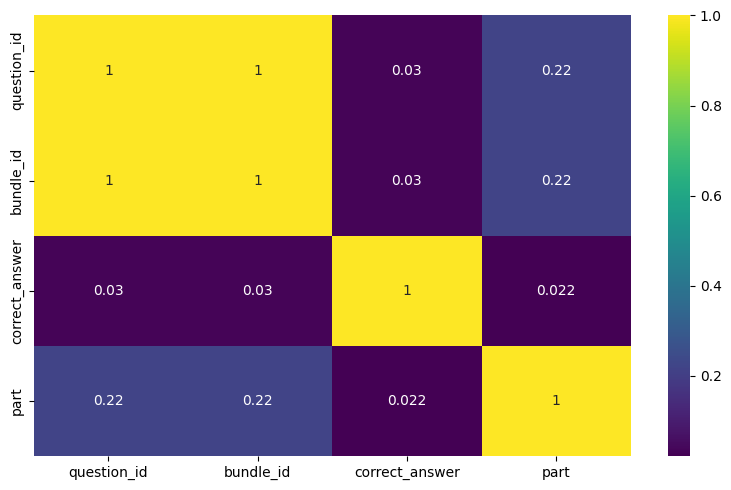

<Axes: >

In [14]:
# Select only numerical features for correlation
numerical_features = train_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Now plot the heatmap
plot_heatmap(correlation_matrix)

## Target variable = answered_correctly

First I would like to see if the number of appearences of 1 ID (1 pupil) corresponds to their overall performance (other words, if you assess 1 student multiple times, will they perform better?)

In [8]:
# Count how many times the user answered correctly out of all available times
user_performance = train_df.groupby("user_id").agg({ 'row_id': ['count'], 'answered_correctly': ['sum'] }).reset_index()
user_performance.columns = ["user_id", "total_count", "correct_count"]
user_performance["performance"] = user_performance["correct_count"] / user_performance["total_count"]

# Create intervals for number of appearences
# between 0 and 1000, 1000 and 2500 and 2500+
def condition(x):
    if x <= 1000:
        return 0
    elif (x > 1000) & (x <= 2500):
        return 1
    else:
        return 2

user_performance["total_interval"] = user_performance["total_count"].applymap(condition)

NameError: name 'train' is not defined

📌Note: So yes, the average performance increases along with the number of times one student appears in the data.

In [ ]:
# Convert to numpy arrays (so we can plot)
x = cupy.asnumpy(user_performance["total_interval"].values)
y = cupy.asnumpy(user_performance["performance"].values)

# Plot
plt.figure(figsize = (18, 4))
sns.barplot(x = x, y = y, palette = custom_colors[2:])
plt.title("Performance over number of appearences", fontsize = 15)
plt.xticks([0, 1, 2], ['<1000', '1000-2500', '2500+']);

del user_performance

# Feature engineering

## Feature creation

One-hot encoding: Converting categorical variables to binary columns

In [ ]:
categorical_cols = ['part', 'type_of']  # Columns for one-hot encoding

lectures_encoded = lectures_df.copy()  # Create a copy of the DataFrame

# Apply one-hot encoding with dtype=int to get binary values and drop original columns
for col in categorical_cols:
    one_hot_encoded = pd.get_dummies(lectures_df[['part', 'type_of']], prefix=['part', 'type'])
    lectures_encoded = pd.concat([lectures_df, one_hot_encoded], axis=1)
    lectures_encoded.drop(columns=[col], inplace=True)  # Drop the original column

lectures_encoded.head()

In [ ]:
categorical_cols = ['correct_answer','part']  # Columns for one-hot encoding

questions_encoded = questions_df.copy()  # Create a copy of the DataFrame

# Apply one-hot encoding with dtype=int to get binary values and drop original columns
for col in categorical_cols:
    one_hot_encoded = pd.get_dummies(questions_df[['correct_answer','part']], prefix=['correct_answer','part'])
    questions_encoded = pd.concat([questions_df, one_hot_encoded], axis=1)
    questions_encoded.drop(columns=[col], inplace=True)  # Drop the original column

questions_encoded.head()

Learning Progress Features

Knowledge growth rate: Change in correctness over time

In [ ]:
# Assuming 'timestamp' or 'prior_question_elapsed_time' exists in your dataset
# First, sort data by user and time
train_sorted = train.sort_values(['user_id', 'timestamp'])  # Replace 'timestamp' with your actual time column

# Create time bins (e.g., by day, week, or by groups of N questions)
# Option 1: By time periods
train_sorted['time_bin'] = pd.cut(train_sorted['timestamp'], bins=10)  # 10 equal time bins

# Option 2: By question sequence (every N questions)
train_sorted['question_seq'] = train_sorted.groupby('user_id').cumcount()
train_sorted['question_bin'] = train_sorted['question_seq'] // 10  # Every 10 questions

# Calculate correctness rate by user and time bin
growth_rate = train_sorted.loc[train_sorted.content_type_id == False,
                               ['user_id', 'time_bin', 'answered_correctly']
                              ].groupby(['user_id', 'time_bin']).agg(['mean'])

growth_rate.columns = ['correctness_rate']
growth_rate = growth_rate.reset_index()

# Calculate the change between consecutive time periods
growth_rate_change = growth_rate.sort_values(['user_id', 'time_bin'])
growth_rate_change['previous_rate'] = growth_rate_change.groupby('user_id')['correctness_rate'].shift(1)
growth_rate_change['growth_rate'] = growth_rate_change['correctness_rate'] - growth_rate_change['previous_rate']

# Calculate average growth rate per user
user_avg_growth = growth_rate_change.groupby('user_id')['growth_rate'].mean()

The average correctness rate for each user (what percentage of questions they answered correctly)

In [ ]:
results_u_final = train.loc[train.content_type_id == False, ['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_final.columns = ['answered_correctly_user']

In [ ]:
 'avg_questions', 'avg_questions_seen'

The average rate at which users received explanations for prior questions

In [ ]:
results_u2_final = train.loc[train.content_type_id == False, ['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_final.columns = ['explanation_mean_user']

In [ ]:
results_u2_final.explanation_mean_user.describe()

How many times a unique question has been answered and what is the percentage of success for each unique question

# Merging datasets

Goal is to merge train, questions and lectures datasets for model building

question_id is a foreign key for the train/test content_id column, when the content type is question (0)

lecture_id is a foreign key for the train/test content_id column, when the content type is lecture (1)

In [ ]:
import pandas as pd

def merge_datasets(train_df, questions_df, lectures_df):
    """
    Merge three datasets: train_df, questions_df, and lectures_df.

    Parameters:
    - train_df: DataFrame containing 'content_id' as the key column
    - questions_df: DataFrame containing 'question_id' that links to 'content_id' in train_df
    - lectures_df: DataFrame containing 'lecture_id' that links to 'content_id' in train_df

    Returns:
    - merged_df: The complete merged DataFrame
    """
    # First, merge train_df with questions_df
    # We'll use a left merge to keep all rows from train_df
    questions_merged = train_df.merge(
        questions_df,
        left_on='content_id',
        right_on='question_id',
        how='left',
        suffixes=('', '_question')
    )

    # Then, merge the resulting DataFrame with lectures_df
    # Again using a left merge to keep all rows from our previous merge
    final_merged = questions_merged.merge(
        lectures_df,
        left_on='content_id',
        right_on='lecture_id',
        how='left',
        suffixes=('', '_lecture')
    )

    # Handle the common part_1 to part_7 columns to avoid confusion
    # For each common column, create a new column that takes the value from either source
    for i in range(1, 8):
        part_col = f'part_{i}'
        question_col = f'{part_col}'  # If no suffix was added in first merge
        lecture_col = f'{part_col}_lecture'

        # Use coalesce logic: take the first non-null value
        # If the value comes from questions_df, use it; otherwise, try lectures_df
        final_merged[f'combined_{part_col}'] = final_merged[question_col].combine_first(
            final_merged[lecture_col]
        )

    return final_merged

# Example usage
# merged_df = merge_datasets(train_df, questions_df, lectures_df)

In [ ]:
merged_df = merge_datasets(train_df, questions_df, lectures_df)

# Train/test

I'll help you understand what this code is doing:

1. `validation = train.groupby('user_id').tail(5)` takes the 5 most recent answers from each user in the dataset and assigns them to a validation set.

2. `train = train[~train.index.isin(validation.index)]` removes these validation samples from the original training set.

3. `len(train) + len(validation)` shows the total number of records (9,804,604) after this split.

4. `len(validation)` would show how many records are in the validation set, but the output isn't shown in your excerpt.

This is a common approach for time-series validation in recommendation systems or user modeling, where you want to validate on each user's most recent interactions. It ensures that your model is evaluated on future data while being trained on past data, which better reflects how it would perform in production.

Using `train_test_split` would create a random split of your data, which isn't ideal for this scenario for several reasons:

1. **Temporal nature of the data**: Since you're working with user answers over time, a random split would mix up the chronological order. By using `groupby('user_id').tail(5)`, you're specifically selecting each user's most recent 5 answers for validation, which preserves the temporal structure.

2. **User-level evaluation**: This approach ensures every user appears in both training and validation sets, which allows you to evaluate how well your model generalizes to new behaviors from the same users.

3. **Cold-start problem avoidance**: A random split might put all of a user's data in either training or testing, creating a "cold-start" scenario where you're evaluating on users you've never seen before. This split avoids that issue.

4. **Realistic deployment scenario**: In a real-world recommendation system, you typically train on users' historical interactions and want to predict their future behavior - this split mimics that scenario.

5. **Leakage prevention**: Taking the most recent interactions prevents data leakage where you train on future data and test on past data, which would give artificially inflated performance metrics.

For time-series data or user interaction data, this chronological split is often more appropriate than a random `train_test_split`.

Stratified sampling by user activity: If some users have many more interactions than others, you might want to stratify your sampling to ensure representation across different user activity levels.

In [ ]:
# First categorize users by activity level
user_counts = train.groupby('user_id').size()
activity_bins = pd.qcut(user_counts, 4, labels=['low', 'medium', 'high', 'very_high'])
train['activity_level'] = train['user_id'].map(activity_bins)

# Then stratify by activity level
from sklearn.model_selection import train_test_split
train_subset, validation = train_test_split(train, test_size=0.2, stratify=train['activity_level'])

# Extra code


In [ ]:
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.countplot(data=train_df, x='answered_correctly')
plt.title('Distribution of answered_correctly')  # Add a title for clarity
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if they overlap
plt.show()

In [ ]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame({'answered_correctly': answered_correctly_counts.index,
                        'count': answered_correctly_counts.values})

plt.figure(figsize=(8, 6))
sns.barplot(data=plot_df, x='answered_correctly', y='count')
plt.title('Distribution of answered_correctly (Full Dataset)')
plt.xticks(rotation=45, ha='right')
plt.show()